In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Load results
with open('model_results_GPT_bert_all.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(results)

# Add model type column
df['model_type'] = df['model_name'].apply(lambda x: 'BERT' if 'bert' in x.lower() else 'GPT')

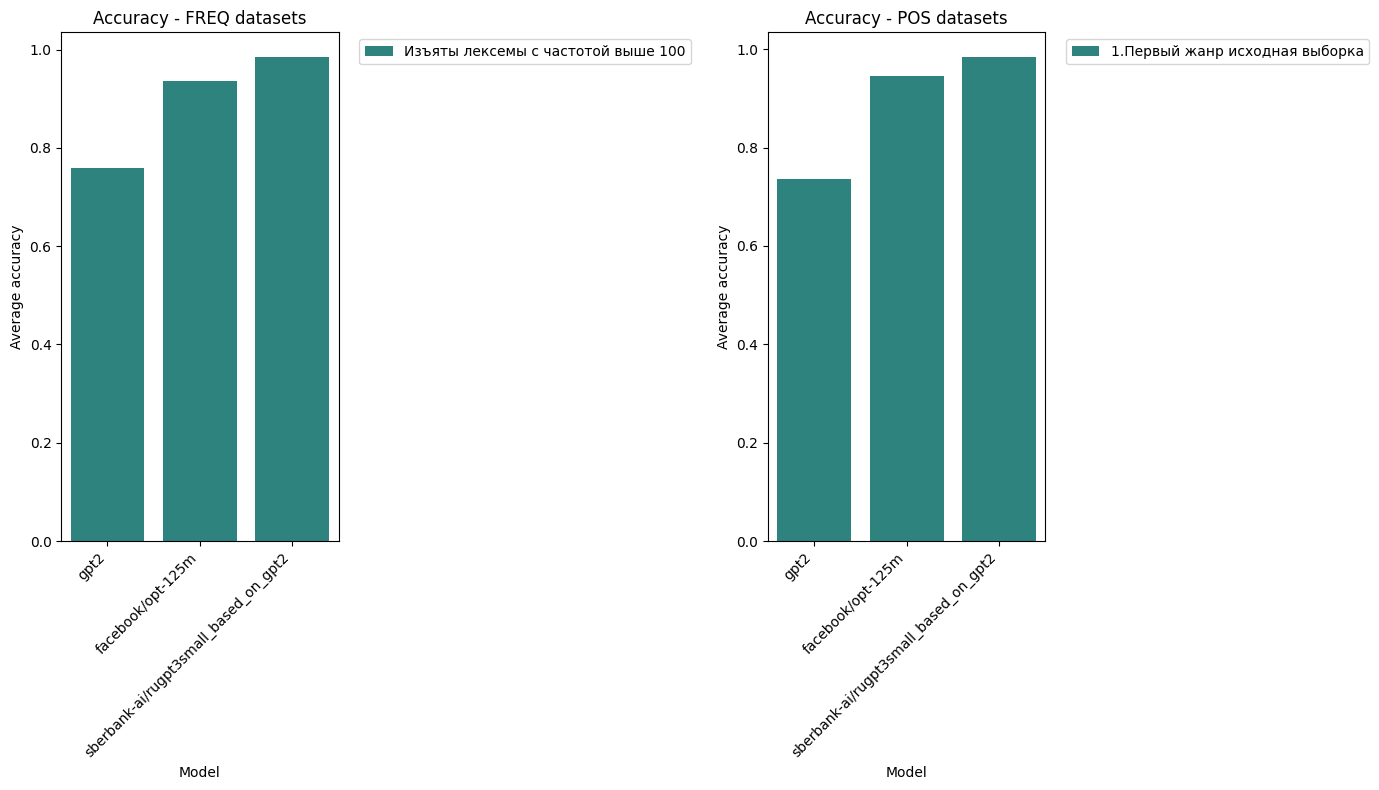

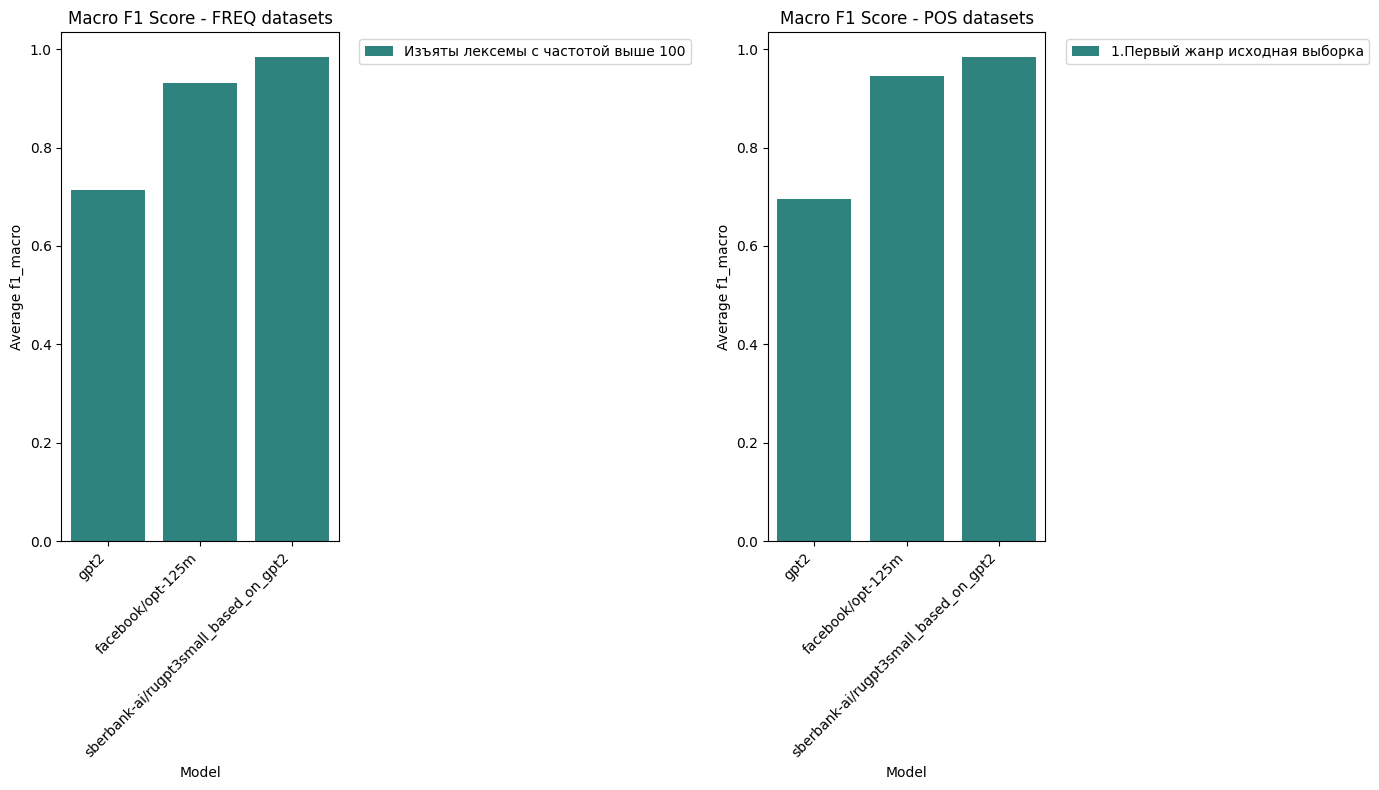

In [2]:
def plot_metric_by_dataset_type(metric, title):
    plt.figure(figsize=(14, 8))
    
    # Split by dataset type
    for dataset_type in ['freq', 'pos']:
        subset = df[df['dataset_type'] == dataset_type]
        
        if not subset.empty:
            plt.subplot(1, 2, 1 if dataset_type == 'freq' else 2)
            sns.barplot(data=subset, x='model_name', y=f'avg_{metric}', hue='dataset_name', 
                        palette='viridis', errorbar='sd')
            plt.title(f'{title} - {dataset_type.upper()} datasets')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel(f'Average {metric}')
            plt.xlabel('Model')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
    plt.tight_layout()
    plt.savefig(f'{metric}_by_dataset_type.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot accuracy and F1
plot_metric_by_dataset_type('accuracy', 'Accuracy')
plot_metric_by_dataset_type('f1_macro', 'Macro F1 Score')

In [3]:
def plot_confusion_matrices():
    # Get unique combinations of models and datasets
    unique_combinations = df[['model_name', 'dataset_name', 'dataset_type']].drop_duplicates()
    
    for _, row in unique_combinations.iterrows():
        model_name = row['model_name']
        dataset_name = row['dataset_name']
        dataset_type = row['dataset_type']
        
        # Find matching result
        result = df[(df['model_name'] == model_name) & 
                    (df['dataset_name'] == dataset_name)].iloc[0]
        
        # Create confusion matrix plot
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(result['true_labels'], result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=["жанр0", "жанр1"], 
                    yticklabels=["жанр0", "жанр1"])
        plt.title(f'Confusion Matrix\n{model_name} - {dataset_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        # Save with descriptive filename
        filename = f"confusion_matrix_{model_name.replace('/', '_')}_{dataset_name.replace(' ', '_')}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close()

plot_confusion_matrices()

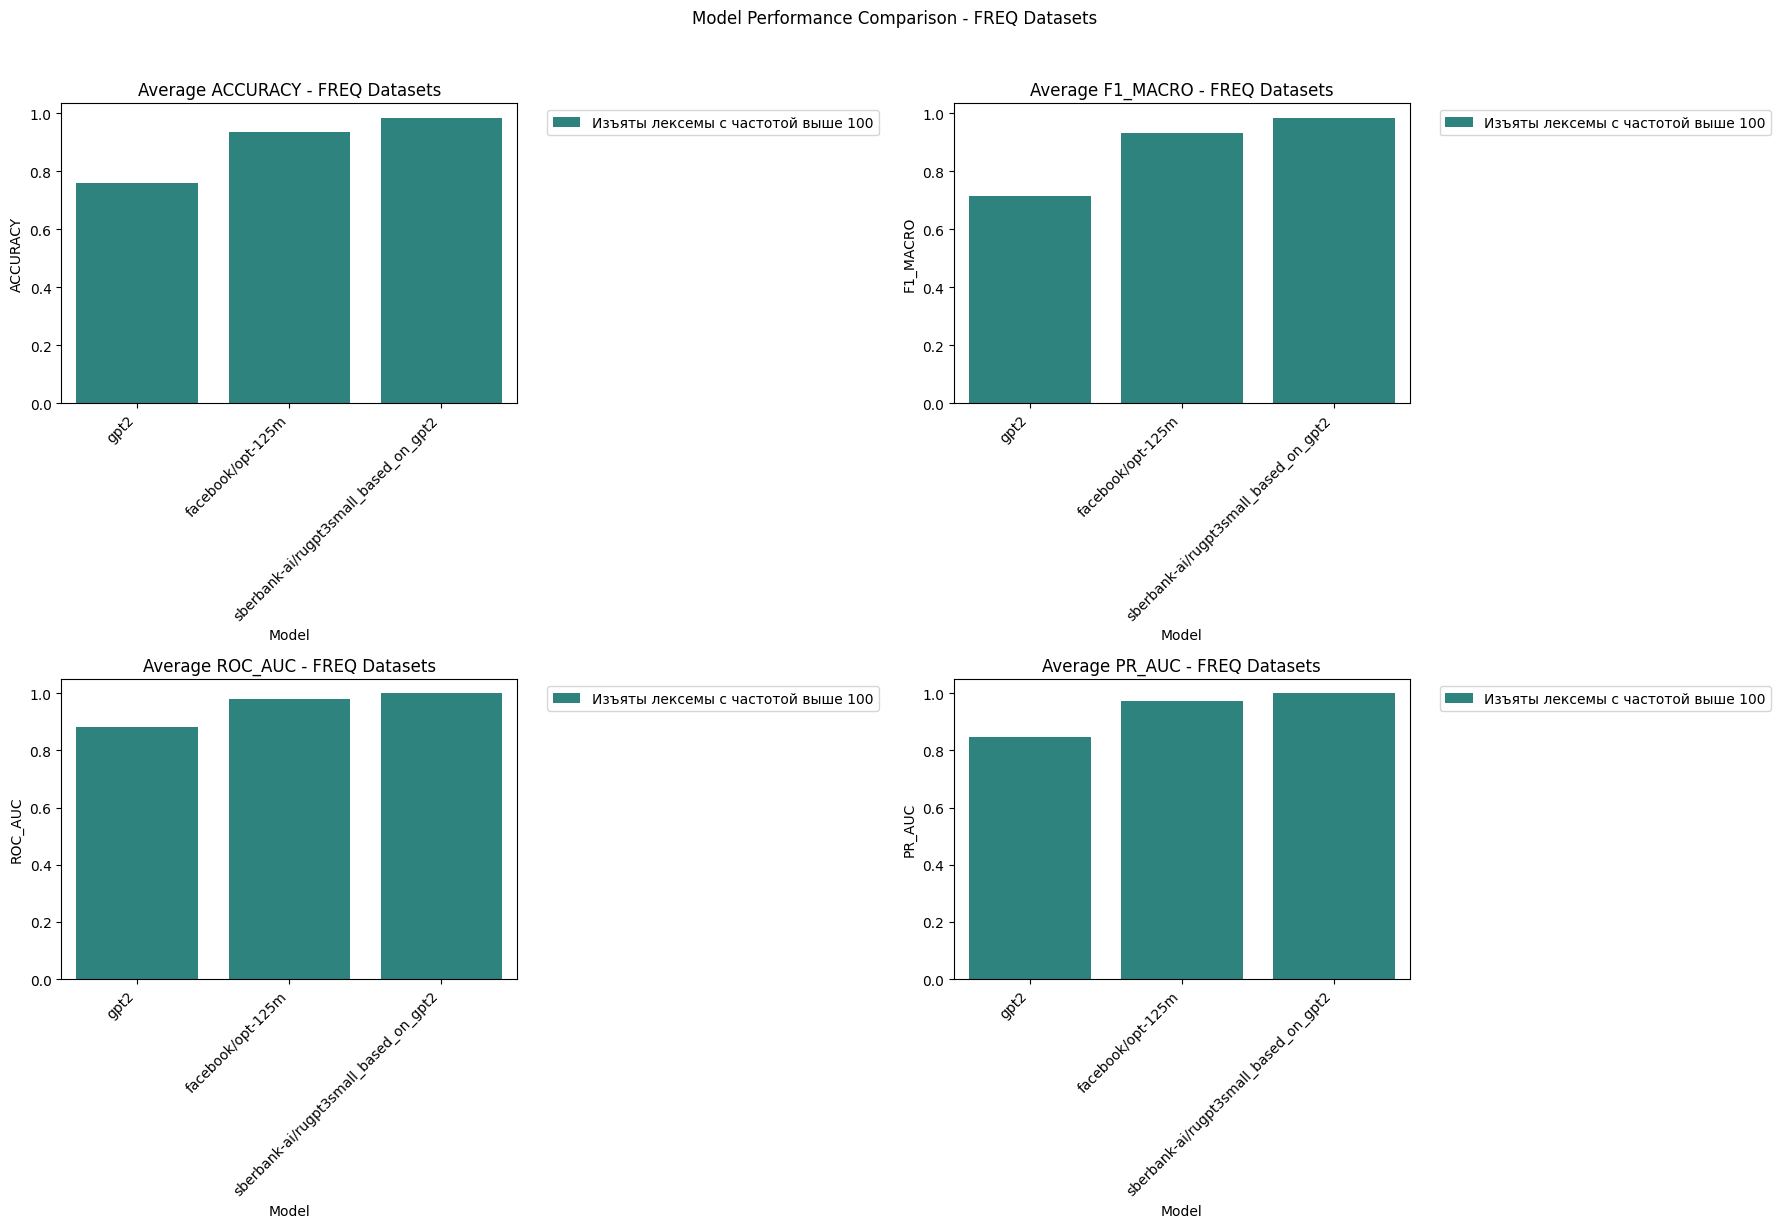

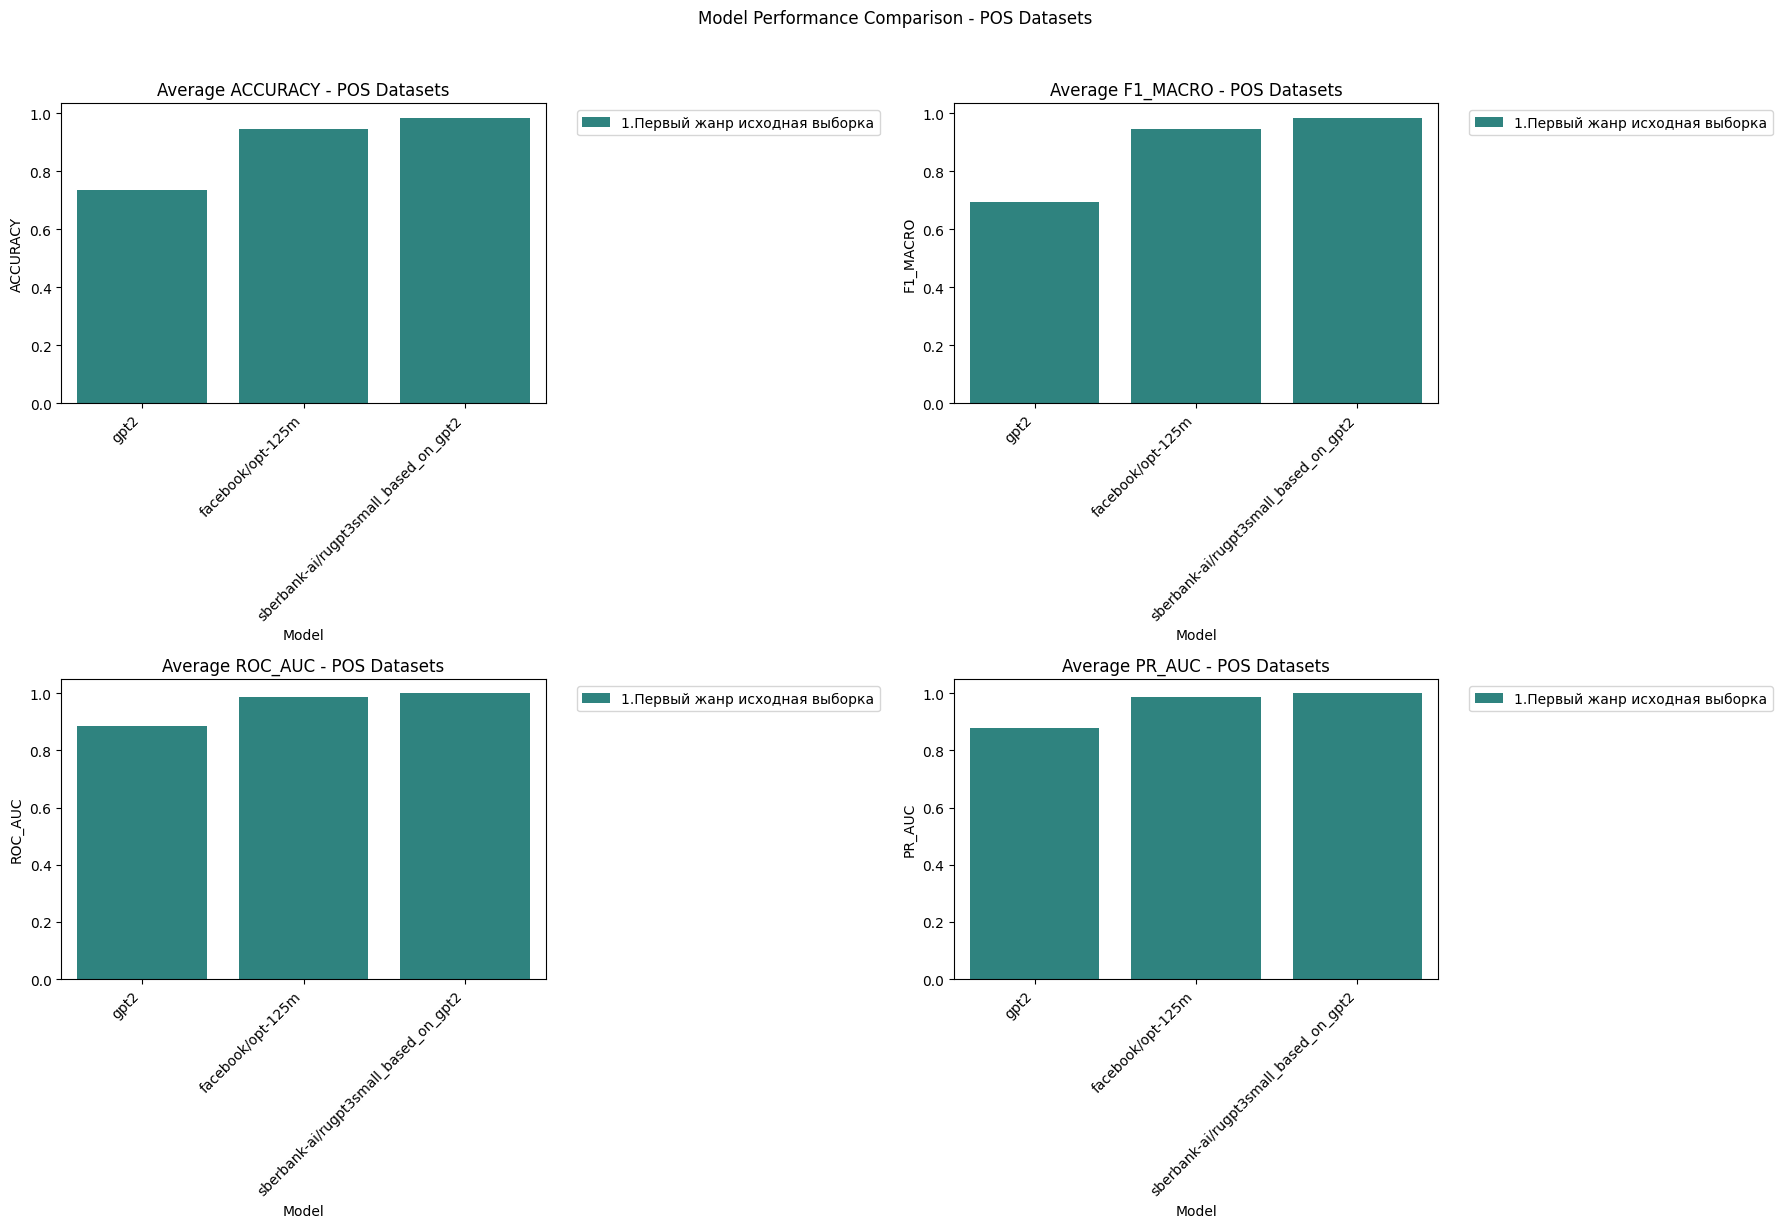

In [4]:
def plot_comprehensive_comparison():
    metrics = ['accuracy', 'f1_macro', 'roc_auc', 'pr_auc']
    n_metrics = len(metrics)
    
    for dataset_type in ['freq', 'pos']:
        subset = df[df['dataset_type'] == dataset_type]
        if subset.empty:
            continue
            
        plt.figure(figsize=(18, 12))
        
        for i, metric in enumerate(metrics, 1):
            plt.subplot(2, 2, i)
            sns.barplot(data=subset, x='model_name', y=f'avg_{metric}', 
                        hue='dataset_name', palette='viridis')
            plt.title(f'Average {metric.upper()} - {dataset_type.upper()} Datasets')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel(metric.upper())
            plt.xlabel('Model')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
        plt.suptitle(f'Model Performance Comparison - {dataset_type.upper()} Datasets', y=1.02)
        plt.tight_layout()
        plt.savefig(f'comprehensive_comparison_{dataset_type}.png', bbox_inches='tight', dpi=300)
        plt.show()

plot_comprehensive_comparison()

In [5]:
def create_performance_tables():
    # Create a table for each dataset type
    for dataset_type in ['freq', 'pos']:
        subset = df[df['dataset_type'] == dataset_type]
        if subset.empty:
            continue
            
        # Select relevant columns
        table_cols = ['model_name', 'dataset_name', 'avg_accuracy', 'std_accuracy', 
                     'avg_f1_macro', 'std_f1_macro', 'avg_roc_auc', 'std_roc_auc']
        
        # Create and display table
        table = subset[table_cols].sort_values(by=['dataset_name', 'avg_accuracy'], ascending=False)
        print(f"\nPerformance Table - {dataset_type.upper()} Datasets:")
        display(table)
        
        # Save to CSV
        table.to_csv(f'performance_table_{dataset_type}.csv', index=False)

create_performance_tables()


Performance Table - FREQ Datasets:


,model_name,dataset_name,avg_accuracy,std_accuracy,avg_f1_macro,std_f1_macro,avg_roc_auc,std_roc_auc
4,sberbank-ai/rugpt3small_based_on_gpt2,Изъяты лексемы с частотой выше 100,0.985656,0.005923,0.984894,0.006164,0.999390,0.000433
2,facebook/opt-125m,Изъяты лексемы с частотой выше 100,0.935148,0.011092,0.931435,0.011342,0.981559,0.004836
0,gpt2,Изъяты лексемы с частотой выше 100,0.759288,0.058344,0.713658,0.086877,0.882013,0.041244



Performance Table - POS Datasets:


,model_name,dataset_name,avg_accuracy,std_accuracy,avg_f1_macro,std_f1_macro,avg_roc_auc,std_roc_auc
5,sberbank-ai/rugpt3small_based_on_gpt2,1.Первый жанр исходная выборка,0.985109,0.005728,0.984910,0.005782,0.999288,0.000539
3,facebook/opt-125m,1.Первый жанр исходная выборка,0.945383,0.012311,0.944468,0.012704,0.986227,0.004821
1,gpt2,1.Первый жанр исходная выборка,0.736500,0.067653,0.694767,0.096292,0.885522,0.046450


Plotting data summary:
                                                    count      mean  std  \
model_name                            dataset_type                         
facebook/opt-125m                     freq            1.0  0.935148  NaN   
                                      pos             1.0  0.945383  NaN   
gpt2                                  freq            1.0  0.759288  NaN   
                                      pos             1.0  0.736500  NaN   
sberbank-ai/rugpt3small_based_on_gpt2 freq            1.0  0.985656  NaN   
                                      pos             1.0  0.985109  NaN   

                                                         min       25%  \
model_name                            dataset_type                       
facebook/opt-125m                     freq          0.935148  0.935148   
                                      pos           0.945383  0.945383   
gpt2                                  freq          0.759288  0.759288  

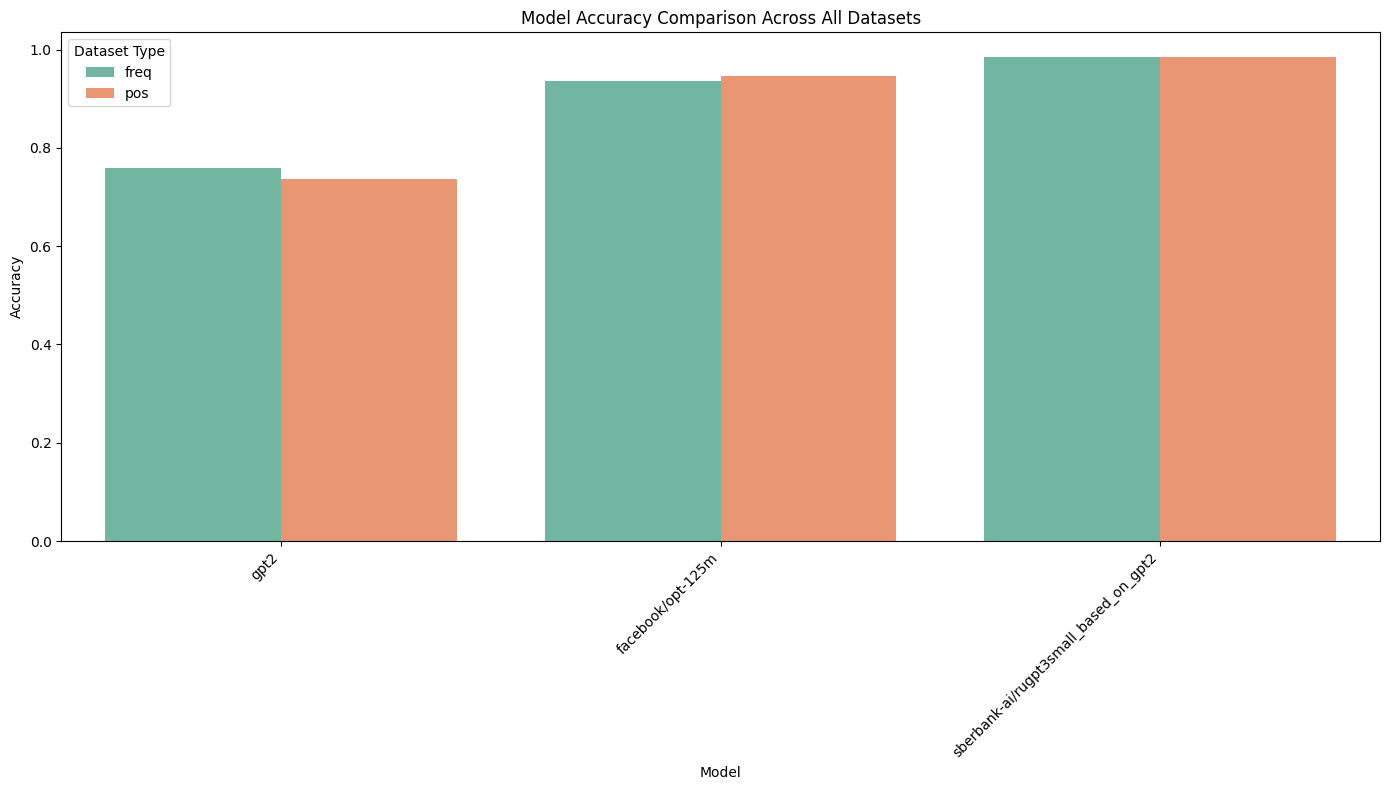

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison():
    # Verificar datos
    if df.empty:
        print("Error: DataFrame is empty")
        return
    if not all(col in df.columns for col in ['model_name', 'avg_accuracy', 'dataset_type']):
        print("Error: Required columns missing in DataFrame")
        return
    if df['avg_accuracy'].isna().all():
        print("Error: All avg_accuracy values are NaN")
        return
    
    print("Plotting data summary:")
    print(df.groupby(['model_name', 'dataset_type'])['avg_accuracy'].describe())
    
    plt.figure(figsize=(14, 8))
    
    # Plot barplot instead of boxplot
    sns.barplot(data=df, x='model_name', y='avg_accuracy', hue='dataset_type', palette='Set2')
    plt.title('Model Accuracy Comparison Across All Datasets')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.legend(title='Dataset Type')
    plt.tight_layout()
    
    # Guardar y mostrar
    plt.savefig('model_comparison_all_datasets.png', bbox_inches='tight', dpi=300)
    plt.show()

plot_model_comparison()

Found 6 unique model-dataset combinations

Processing 1/6: gpt2 - Изъяты лексемы с частотой выше 100
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[110.66666666666667, 5.166666666666667], [42.166666666666664, 38.0]]


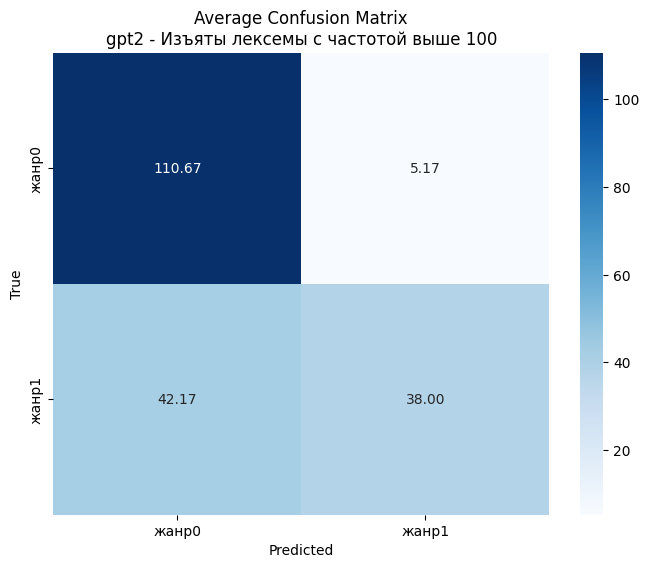


Processing 2/6: gpt2 - 1.Первый жанр исходная выборка
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[84.0, 4.333333333333333], [38.166666666666664, 35.0]]


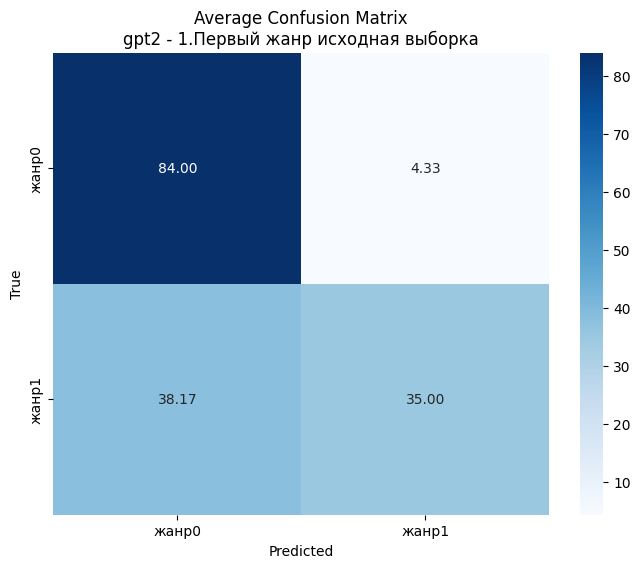


Processing 3/6: facebook/opt-125m - Изъяты лексемы с частотой выше 100
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[114.16666666666667, 5.666666666666667], [7.0, 68.66666666666667]]


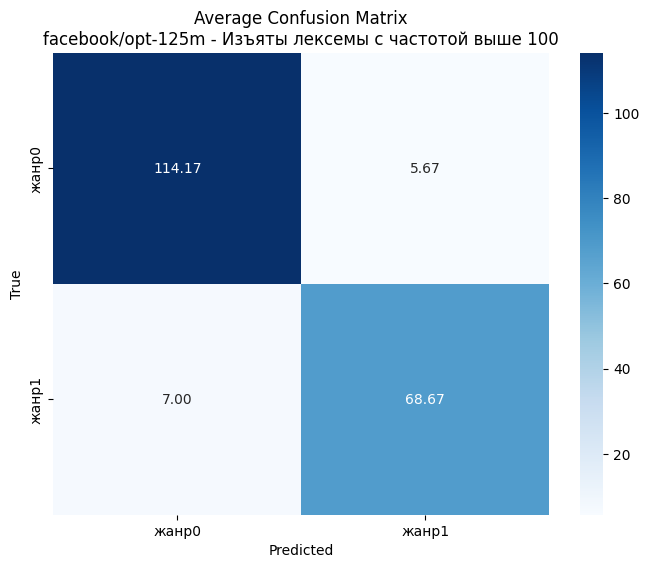


Processing 4/6: facebook/opt-125m - 1.Первый жанр исходная выборка
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[87.33333333333333, 3.5], [5.5, 68.16666666666667]]


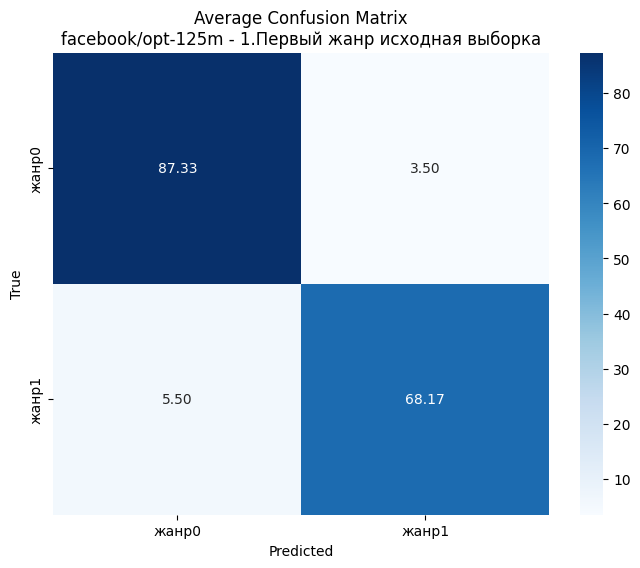


Processing 5/6: sberbank-ai/rugpt3small_based_on_gpt2 - Изъяты лексемы с частотой выше 100
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[118.33333333333333, 1.3333333333333333], [1.5, 76.0]]


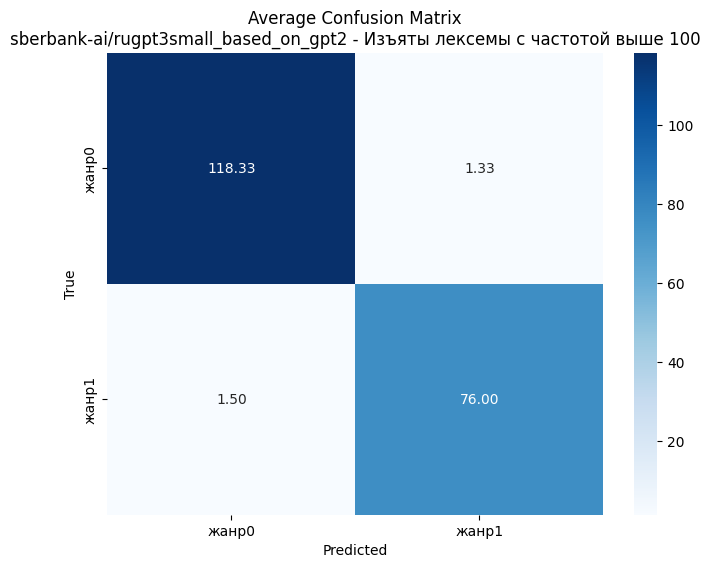


Processing 6/6: sberbank-ai/rugpt3small_based_on_gpt2 - 1.Первый жанр исходная выборка
Found matching result with keys: Index(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy',
       'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro',
       'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1',
       'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc',
       'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies',
       'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs',
       'pr_aucs', 'log_losses', 'losses', 'avg_confusion_matrix',
       'confusion_matrices', 'type', 'true_labels', 'predictions',
       'model_type'],
      dtype='object')
Average confusion matrix values: [[92.0, 0.6666666666666666], [1.8333333333333333, 73.83333333333333]]


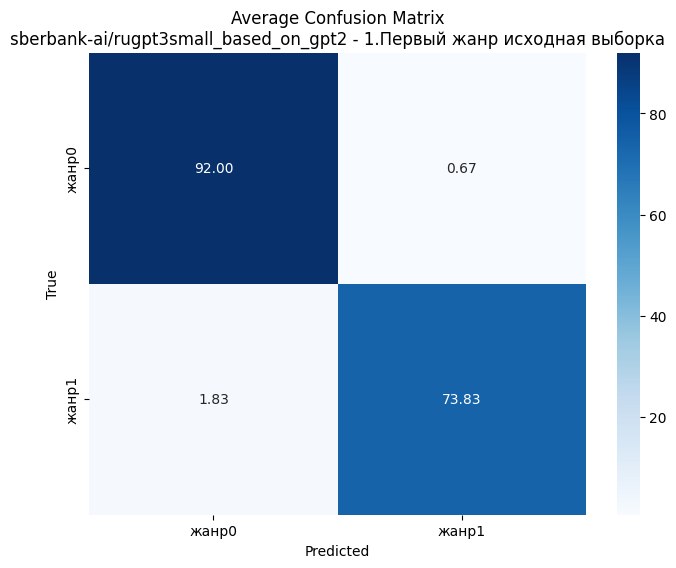

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_confusion_matrices_debug():
    unique_combinations = df[['model_name', 'dataset_name']].drop_duplicates()
    print(f"Found {len(unique_combinations)} unique model-dataset combinations")
    
    for i, (_, row) in enumerate(unique_combinations.iterrows(), 1):
        model_name = row['model_name']
        dataset_name = row['dataset_name']
        
        print(f"\nProcessing {i}/{len(unique_combinations)}: {model_name} - {dataset_name}")
        
        try:
            result = df[(df['model_name'] == model_name) & 
                       (df['dataset_name'] == dataset_name)].iloc[0]
            
            print("Found matching result with keys:", result.keys())
            
            if 'avg_confusion_matrix' not in result:
                print("Missing 'avg_confusion_matrix' in result")
                continue
                
            plt.figure(figsize=(8, 6))
            cm = result['avg_confusion_matrix']
            print("Average confusion matrix values:", cm)
            
            sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',  # Use '.2f' for floating-point values
                       xticklabels=["жанр0", "жанр1"],
                       yticklabels=["жанр0", "жанр1"])
            plt.title(f'Average Confusion Matrix\n{model_name} - {dataset_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            
            plt.show()
            
        except Exception as e:
            print(f"Error processing {model_name} - {dataset_name}: {str(e)}")
            continue

# Ejecutar con depuración
plot_confusion_matrices_debug()

Encontradas 6 combinaciones únicas de modelo y dataset

Procesando combinación 1/6: gpt2 - Изъяты лексемы с частотой выше 100
Número de matrices de confusión (folds): 6


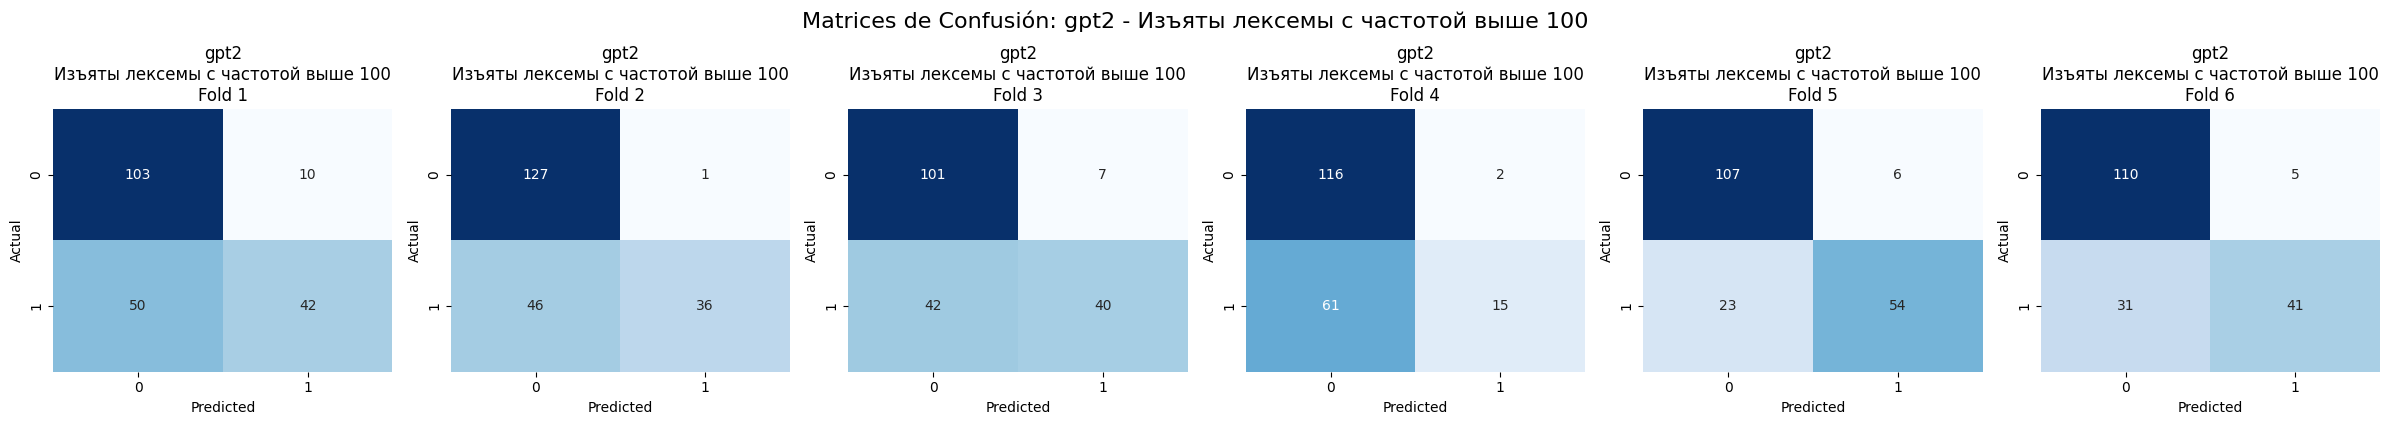


Procesando combinación 2/6: gpt2 - 1.Первый жанр исходная выборка
Número de matrices de confusión (folds): 6


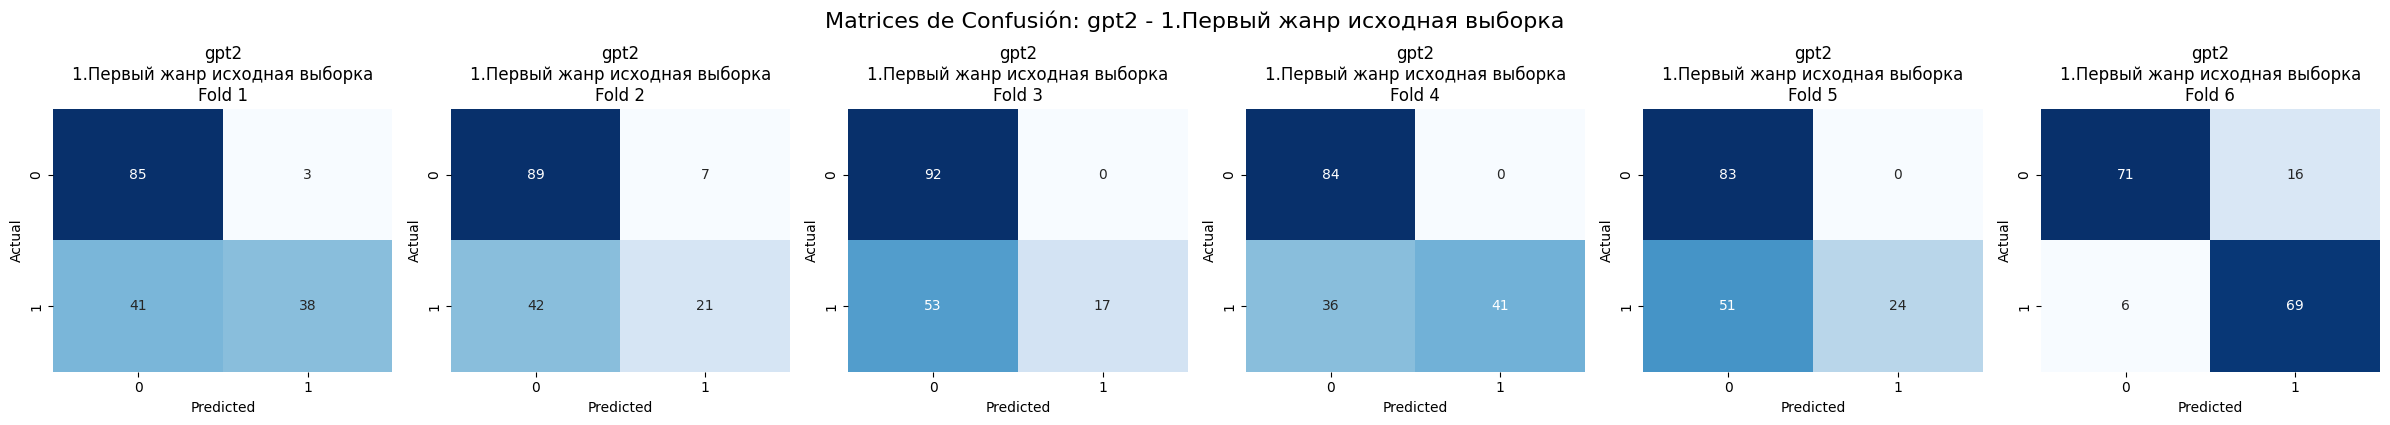


Procesando combinación 3/6: facebook/opt-125m - Изъяты лексемы с частотой выше 100
Número de matrices de confusión (folds): 6
Error procesando facebook/opt-125m - Изъяты лексемы с частотой выше 100: [Errno 2] No such file or directory: 'confusion_matrices_facebook/opt-125m_Изъяты лексемы с частотой выше 100.png'

Procesando combinación 4/6: facebook/opt-125m - 1.Первый жанр исходная выборка
Número de matrices de confusión (folds): 6
Error procesando facebook/opt-125m - 1.Первый жанр исходная выборка: [Errno 2] No such file or directory: 'confusion_matrices_facebook/opt-125m_1.Первый жанр исходная выборка.png'

Procesando combinación 5/6: sberbank-ai/rugpt3small_based_on_gpt2 - Изъяты лексемы с частотой выше 100
Número de matrices de confusión (folds): 6
Error procesando sberbank-ai/rugpt3small_based_on_gpt2 - Изъяты лексемы с частотой выше 100: [Errno 2] No such file or directory: 'confusion_matrices_sberbank-ai/rugpt3small_based_on_gpt2_Изъяты лексемы с частотой выше 100.png'

Proces

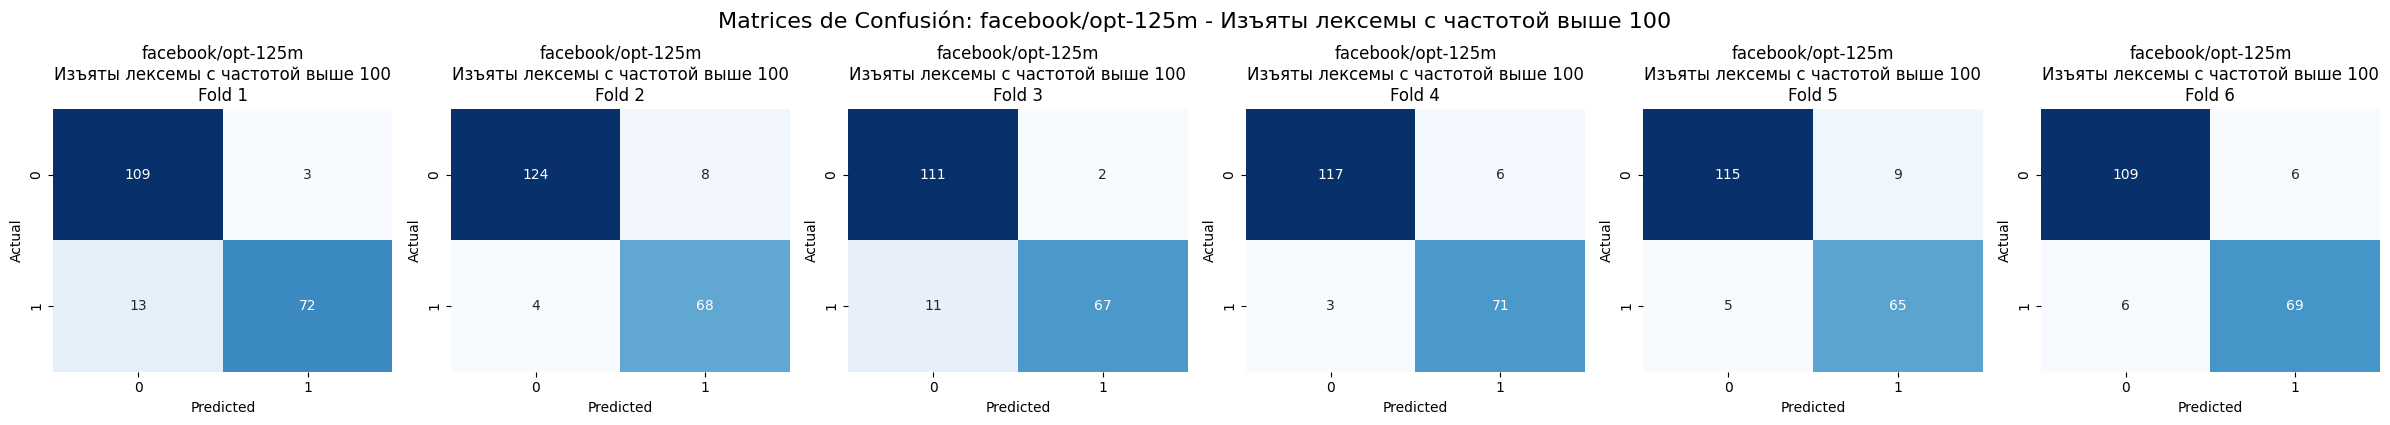

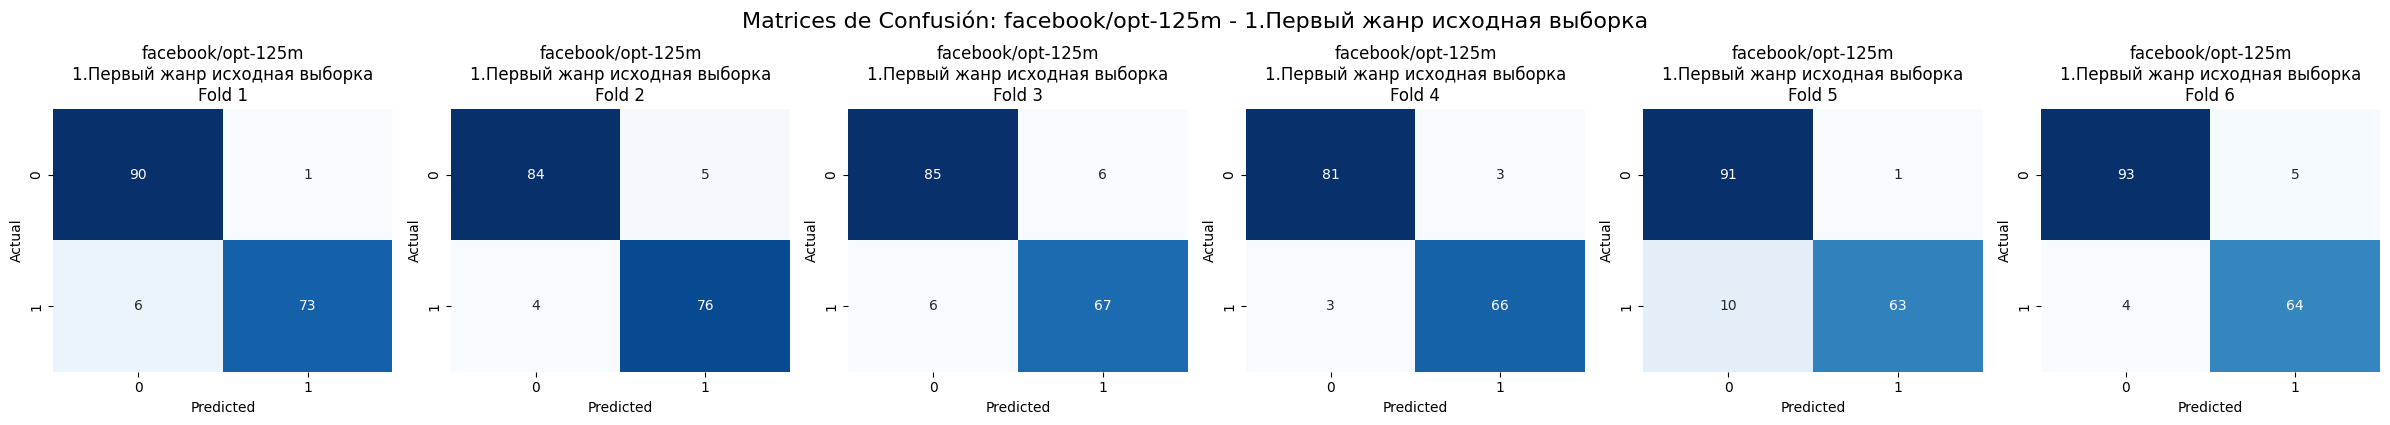

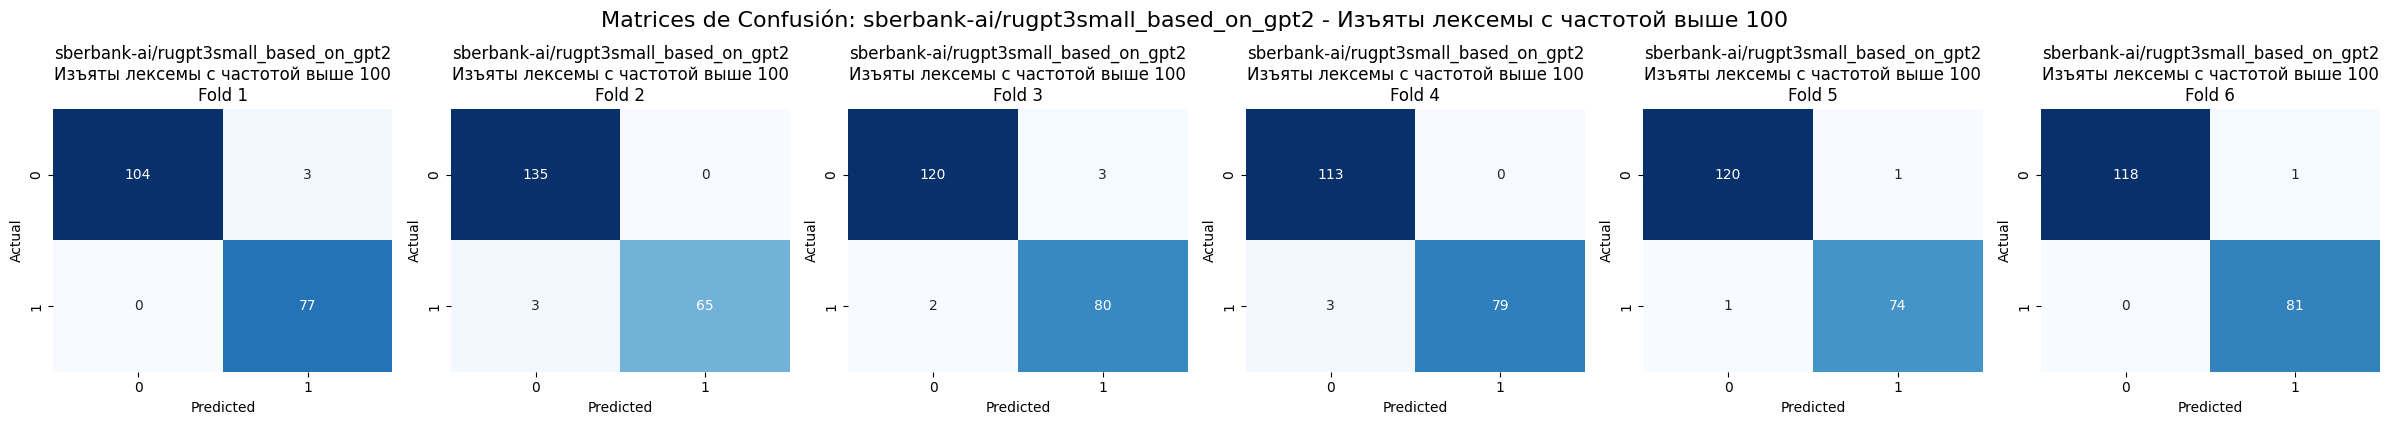

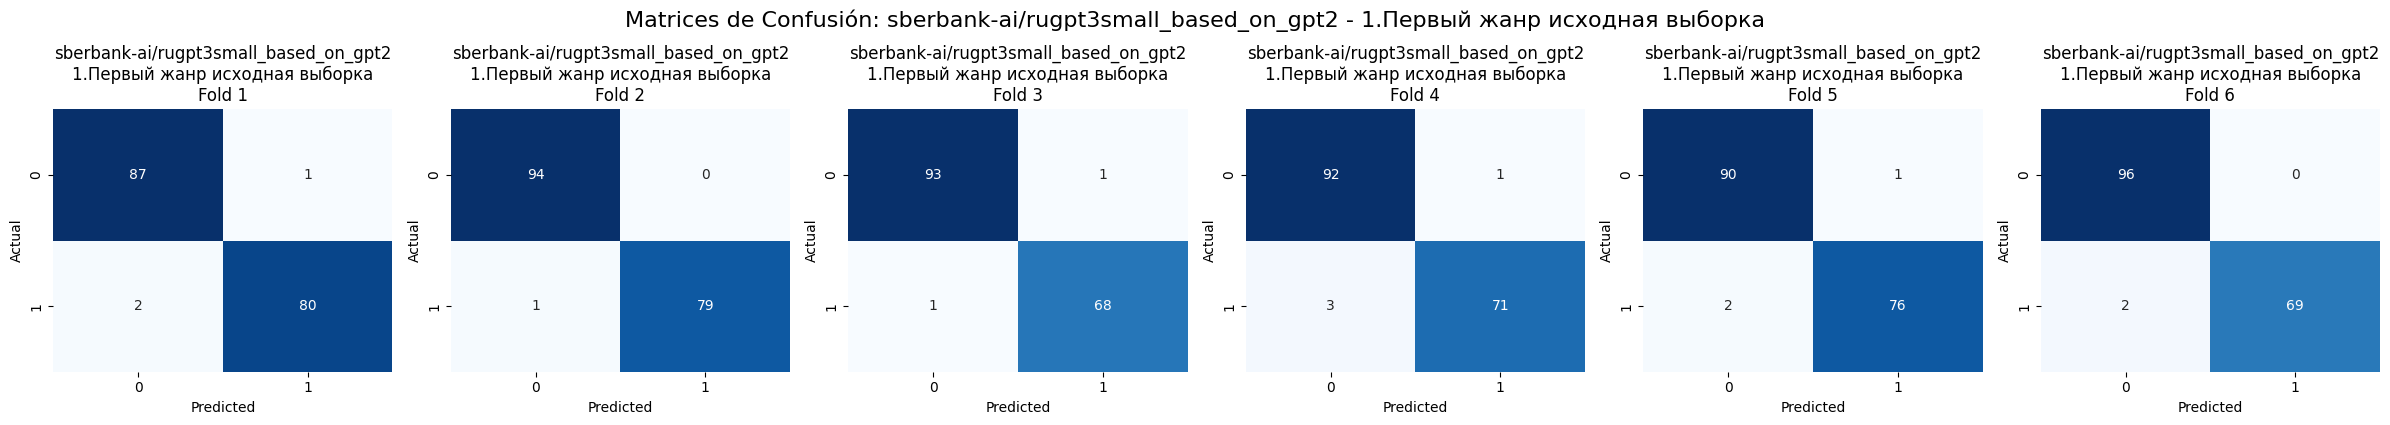

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(json_file='model_results_GPT_bert_all.json'):
    # Cargar resultados desde el JSON
    with open(json_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convertir a DataFrame
    df = pd.DataFrame(results)
    
    # Verificar columnas necesarias
    required_columns = ['model_name', 'dataset_name', 'confusion_matrices']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: El DataFrame no contiene todas las columnas necesarias: {required_columns}")
        return
    
    # Agrupar por modelo y dataset
    unique_combinations = df[['model_name', 'dataset_name']].drop_duplicates()
    print(f"Encontradas {len(unique_combinations)} combinaciones únicas de modelo y dataset")
    
    # Iterar sobre cada combinación
    for idx, (_, row) in enumerate(unique_combinations.iterrows()):
        model_name = row['model_name']
        dataset_name = row['dataset_name']
        
        print(f"\nProcesando combinación {idx + 1}/{len(unique_combinations)}: {model_name} - {dataset_name}")
        
        try:
            # Obtener el registro correspondiente
            result = df[(df['model_name'] == model_name) & (df['dataset_name'] == dataset_name)].iloc[0]
            
            # Verificar matrices de confusión
            conf_matrices = result.get('confusion_matrices', [])
            if not conf_matrices:
                print(f"No se encontraron matrices de confusión para {model_name} - {dataset_name}")
                continue
            
            # Determinar el número de folds (corridas)
            num_folds = len(conf_matrices)
            print(f"Número de matrices de confusión (folds): {num_folds}")
            
            # Crear figura con subgráficos
            fig, axes = plt.subplots(nrows=1, ncols=num_folds, figsize=(4 * num_folds, 4))
            if num_folds == 1:
                axes = [axes]  # Convertir a lista para un solo subplot
            
            # Graficar cada matriz de confusión
            for col_idx, matrix in enumerate(conf_matrices):
                ax = axes[col_idx]
                sns.heatmap(np.array(matrix), annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
                ax.set_title(f"{model_name}\n{dataset_name}\nFold {col_idx + 1}")
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")
            
            plt.tight_layout()
            plt.suptitle(f"Matrices de Confusión: {model_name} - {dataset_name}", fontsize=16, y=1.05)
            plt.savefig(f'confusion_matrices_{model_name}_{dataset_name}.png', bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error procesando {model_name} - {dataset_name}: {str(e)}")
            continue

# Ejecutar la función
plot_confusion_matrices()